In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)

def nearest_nonzero_idx(a,x,y):
    r,c = np.nonzero(a)
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return r[min_idx], c[min_idx]


def maskedarray_gt(data, value, set_value=None):
    """ Greater than operation on masked array to avoid warning errors """
    if set_value is None:
        set_value = value
    data = np.nan_to_num(data,0)
    data[data > value] = set_value
    return data


def maskedarray_lt(data, value, set_value=None):
    """ Less than operation on masked array to avoid warning errors """
    if set_value is None:
        set_value = value
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Glacier mask
    glac_mask = np.zeros(vel_x_raw.shape) + 1
    glac_mask[gf.z1.mask] = 0
    
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
        icethickness = icethickness * glac_mask
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
         
    # Redistribute off-glacier volume back onto the nearest pixel on the glacier
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
            
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    if debug:
        print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() < 0.01)
        print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
              np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
    if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
        print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity



class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.emvel = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan
        self.dc_area = None

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()
        
        
#RGI uses 50 m bins
def hist_plot(gf, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True, csv_ending='', mb_df=None):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this
    if mb_df is not None:
        # Align bins with mass balance data
        bin_center_min = mb_df.loc[0,'# bin_center_elev_m']
        while bin_center_min > gf.z1.min() + bin_width/2:
            bin_center_min -= mb_bin_size
        bin_center_max = mb_df['# bin_center_elev_m'].values[-1]
        while bin_center_max < gf.z1.max():
            bin_center_max += mb_bin_size    
        z_bin_centers = np.arange(bin_center_min, bin_center_max + mb_bin_size/2, mb_bin_size)
        z_bin_edges = np.arange(bin_center_min - mb_bin_size / 2, bin_center_max + mb_bin_size, mb_bin_size)
    else:
        z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
        
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc
        
    if gf.dc_area is not None:
#         z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
#         #Need to compress here, otherwise histogram uses masked values!
#         z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
#         z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
#         #RGI standard is integer thousandths of glaciers total area
#         #Should check to make sure sum of bin areas equals total area
#         #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
#         z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
        
# #         dc_bin_edges, dc_bin_centers = malib.get_bins(gf.dc_area, bin_width)
        dc_bin_counts, dc_bin_edges = np.histogram(gf.dc_area.compressed(), bins=z_bin_edges)
        dc_bin_areas = dc_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #RGI standard is integer thousandths of glaciers total area
        dc_bin_areas_perc = 100. * (dc_bin_areas / gf.glac_area_km2)

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.emvel is not None:
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_med = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(z1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
        
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
        if gf.emvel is not None:
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
                emvel_bin_med[bin_n] = malib.fast_median(emvel_bin_samp)
                emvel_bin_mad[bin_n] = malib.mad(emvel_bin_samp)
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.dc_area is not None:
        outbins_header += ', dc_bin_count_valid, dc_bin_area_valid_km2, dc_bin_area_perc'
        fmt += ', %0.0f, %0.3f, %0.2f'
        outbins.extend([dc_bin_counts, dc_bin_areas, dc_bin_areas_perc])
#         outbins.extend([z1_bin_counts, z1_bin_areas, z1_bin_areas_perc])
        
        
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',debris_thick_ts_med_m,debris_thick_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',meltfactor_ts_med_m,meltfactor_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med > 1] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad > 1] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_med, meltfactor_ts_mad])
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    if gf.emvel is not None:
        outbins_header += ', emvel_mean, emvel_std, emvel_med, emvel_mad'
        fmt += ', %0.3f, %0.3f, %0.3f, %0.3f'
        outbins.extend([emvel_bin_mean, emvel_bin_std, emvel_bin_med, emvel_bin_mad])
    
    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    outbins_df['debris_perc'] = outbins_df[' dc_bin_count_valid'] / outbins_df[' z1_bin_count_valid'] * 100
    
    if mb_df is not None:
        # ADD MASS BALANCE DATA
        mb_df = mb_df[np.isfinite(mb_df['# bin_center_elev_m'])]
        mb_df.reset_index(inplace=True, drop=True)
        # start index for merge
        if mb_df.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            mb_df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == mb_df.loc[0,'# bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            mb_df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == mb_df['# bin_center_elev_m'])[0][0]
    #     print('idx1:', 
    #           '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
    #           '\ndfbins:', mb_df_idx1, mb_df.loc[mb_df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= mb_df.loc[mb_df.shape[0]-1,'# bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == mb_df.loc[mb_df.shape[0]-1,'# bin_center_elev_m'])[0][0]
            mb_df_idx2 = mb_df.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            mb_df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == mb_df['# bin_center_elev_m'])[0][0]
    #     print('idx2:', 
    #           '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
    #           '\ndfbins:', mb_df_idx2, mb_df.loc[mb_df_idx2,'# bin_center_elev_m'])
        outbins_df[' mb_bin_mean_mwea'] = np.nan
        outbins_df[' mb_bin_std_mwea'] = np.nan
        outbins_df[' mb_bin_area_valid_km2'] = np.nan
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_mean_mwea'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' mb_bin_mean_mwea']
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_std_mwea'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' mb_bin_std_mwea']
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_area_valid_km2'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' z1_bin_area_valid_km2']
        try:
            outbins_df['startyear'] = mb_df.loc[mb_df_idx1,'startyear']
            outbins_df['endyear'] = mb_df.loc[mb_df_idx1,'endyear']
        except:
            outbins_df['startyear'] = 2000
            outbins_df['endyear'] = 2012
    
    if exportcsv:
        if int(gf.feat_fn.split('.')[0]) < 10:
            outbins_fullfn = os.path.join(input.mb_binned_fp, gf.feat_fn[0:7] + csv_ending)
        else:
            outbins_fullfn = os.path.join(input.mb_binned_fp, gf.feat_fn[0:8] + csv_ending)
        outbins_df.to_csv(outbins_fullfn, index=False)
#         np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    
    return outbins_df, z_bin_edges
#     return z_bin_edges

In [4]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""

import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from scipy import ndimage
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib


import globaldebris_input as input

#INPUT
# topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
#Output directory
# outdir = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins/'

# outdir = input.output_fp + 'mb_bins/'
# outdir_fig = outdir + '/figures/'
# outdir_csv = outdir + '/csv/'

# if os.path.exists(outdir) == False:
#     os.makedirs(outdir)
# if os.path.exists(input.glac_shp_proj_fp) == False:
#     os.makedirs(input.glac_shp_proj_fp)
# if os.path.exists(outdir_csv) == False:
#     os.makedirs(outdir_csv)
# if os.path.exists(outdir_fig) == False:
#     os.makedirs(outdir_fig)


csv_ending = '_mb_bins_wdc_emvel_offset.csv'
verbose = False
close_fig = True
extra_layers = True

# #RGI inventory
# glac_str = '15.03473' # Ngozumpa

# met_sample_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/' + 
#                      'rounce_model/hma_data/' + input.roi + '_ERA5-metdata_2000_2018-z.nc')
# debris_elevstats_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/' +
#                            'rounce_model/hma_data/' + input.roi + '_debris_elevstats.nc')

# glac_shp_fn_dict = {'13':topdir + '../RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
#                     '14':topdir + '../RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
#                     '15':topdir + '../RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}

# glac_shp_fn = glac_shp_fn_dict[region]
# glacfeat_fn = outdir + 'glacfeat_list.p'

In [5]:
# Debris cover extent shapefile with statistics
dc_shp = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])

# Subset by percent debris-covered or debris-covered area
dc_shp_subset = dc_shp[((dc_shp['DC_Area__1'] > input.dc_percarea_threshold) | 
                        (dc_shp['DC_Area_v2'] / 1e6 > input.dc_area_threshold))
                        & (dc_shp['Area'] > input.min_glac_area)].copy()
dc_shp_subset.reset_index(inplace=True, drop=True)
dc_shp_subset['CenLon_360'] = dc_shp_subset['CenLon']
dc_shp_subset.loc[dc_shp_subset['CenLon_360'] < 0, 'CenLon_360'] = 360 + dc_shp_subset.loc[dc_shp_subset['CenLon_360'] < 0, 'CenLon_360']
dc_shp_subset

# # # ===== LOAD RGI DATA (works for multiple regions together) =====
# # rgi_fns = []
# # for i in os.listdir(input.rgi_fp):
# # #     print(i)
# #     for reg_no in input.roi_rgidict[input.roi]:
# #         reg_str = str(reg_no).zfill(2)
# #         if i.startswith(reg_str) and i.endswith('.csv'):
# #             rgi_fns.append(i)
# # rgi_fns = sorted(rgi_fns)

# # # Load RGI data
# # rgi_data = None
# # for i in rgi_fns:
# #     rgi_reg = pd.read_csv(input.rgi_fp + i)
    
# #     if rgi_data is None:
# #         rgi_data = rgi_reg
# #     else:
# #         rgi_data = pd.concat((rgi_data, rgi_reg), axis=0)
# # rgi_data.reset_index(inplace=True, drop=True)
# # rgi_data

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,DC_Area,DC_BgnDate,DC_EndDate,DC_CTSmean,DC_Area_%,area_singl,DC_Area_v2,DC_Area__1,geometry,CenLon_360
0,RGI60-16.00080,G289192E15597S,20009999,20030531,-70.808481,-15.597843,16,1,2.350,5015,...,1879200,2013,2017,13.879310,79.966,2000329,2000329,85.120,"POLYGON ((-70.82284 -15.60048, -70.82256 -15.6...",289.191519
1,RGI60-16.00141,G289250E15308S,20009999,20030531,-70.746611,-15.311424,16,1,2.558,4944,...,2374200,2013,2017,19.909379,92.815,2451201,2451201,95.825,"POLYGON ((-70.76950 -15.31381, -70.76922 -15.3...",289.253389
2,RGI60-16.00163,G289304E15345S,20009999,20030531,-70.698399,-15.343793,16,1,2.305,4988,...,1108800,2013,2017,15.175185,48.104,650462,1081444,46.917,"MULTIPOLYGON (((-70.70664 -15.34792, -70.70636...",289.301601
3,RGI60-16.00173,G289290E15376S,20009999,20030531,-70.707924,-15.374475,16,1,2.115,4952,...,365400,2013,2017,21.383340,17.277,130158,302953,14.324,"MULTIPOLYGON (((-70.71444 -15.37876, -70.71416...",289.292076
4,RGI60-16.00176,G289280E15353S,20009999,20030531,-70.707928,-15.357731,16,1,2.546,4987,...,903600,2013,2017,22.217345,35.491,50399,853055,33.506,"MULTIPOLYGON (((-70.70505 -15.35796, -70.70477...",289.292072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,RGI60-16.02497,G282309E08904S,20031018,-9999999,-77.693319,-8.900989,16,1,3.398,4638,...,522000,2013,2017,8.423199,15.362,508587,508587,14.967,"POLYGON ((-77.70315 -8.91299, -77.70287 -8.912...",282.306681
205,RGI60-16.02518,G282284E08882S,20031018,-9999999,-77.715349,-8.882387,16,1,3.588,4637,...,318600,2013,2017,7.594425,8.880,315452,315452,8.792,"POLYGON ((-77.72666 -8.88517, -77.72611 -8.885...",282.284651
206,RGI60-16.02566,G282336E08900S,20031018,-9999999,-77.666773,-8.899181,16,1,2.068,4639,...,336600,2013,2017,6.900700,16.277,324467,324467,15.690,"POLYGON ((-77.67363 -8.90290, -77.67336 -8.902...",282.333227
207,RGI60-16.02586,G282308E08800S,20031018,-9999999,-77.691744,-8.796642,16,1,2.136,4703,...,452700,2013,2017,3.780303,21.194,128523,406914,19.050,"MULTIPOLYGON (((-77.69772 -8.80488, -77.69718 ...",282.308256


In [6]:
# ===== SELECT GLACIERS WITH DEBRIS ====
ds = xr.open_dataset(input.metdata_fp + '../' + input.metdata_elev_fn)
#  argmin() finds the minimum distance between the glacier lat/lon and the GCM pixel
lat_nearidx = (np.abs(dc_shp_subset['CenLat'].values[:,np.newaxis] - 
                      ds['latitude'][:].values).argmin(axis=1))
lon_nearidx = (np.abs(dc_shp_subset['CenLon_360'].values[:,np.newaxis] - 
                      ds['longitude'][:].values).argmin(axis=1))

latlon_nearidx = list(zip(lat_nearidx, lon_nearidx))
latlon_nearidx_unique = sorted(list(set(latlon_nearidx)))
dc_shp_subset['latlon_nearidx'] = latlon_nearidx
latlon_unique_dict = dict(zip(latlon_nearidx_unique,np.arange(0,len(latlon_nearidx_unique))))
latlon_unique_dict_reversed = dict(zip(np.arange(0,len(latlon_nearidx_unique)),latlon_nearidx_unique))
dc_shp_subset['latlon_unique_no'] = dc_shp_subset['latlon_nearidx'].map(latlon_unique_dict)

print('unique lat/lons:', len(np.unique(dc_shp_subset['latlon_unique_no'])), '\n\n')
# print(dc_shp_subset_wdata.loc[0:5,['RGIId', 'CenLat', 'CenLon', 'larsen_fn', 'braun_fn', 'latlon_unique_no']])

lat_list = np.array([ds.latitude[x[0]].values for x in latlon_nearidx_unique])
lon_list = np.array([ds.longitude[x[1]].values for x in latlon_nearidx_unique])
latlon_list = list(tuple(zip(list(lat_list), list(lon_list))))

print(latlon_list)

# Pickle unique lat/lons that will be used for melt model
with open(input.latlon_unique_fp + input.latlon_unique_dict[input.roi], 'wb') as f:
    pickle.dump(latlon_list, f)

unique lat/lons: 55 


[(10.75, 286.25), (6.5, 287.75), (4.75, 284.75), (3.0, 284.0), (0.0, 282.0), (-0.5, 281.75), (-0.75, 281.25), (-0.75, 281.5), (-1.5, 281.25), (-1.75, 281.5), (-2.0, 281.75), (-8.75, 282.25), (-9.0, 282.25), (-9.0, 282.5), (-9.25, 282.5), (-9.25, 282.75), (-9.5, 282.5), (-9.5, 282.75), (-10.0, 282.75), (-10.25, 283.0), (-10.5, 283.25), (-13.0, 287.75), (-13.25, 287.25), (-13.25, 287.5), (-13.25, 287.75), (-13.25, 288.0), (-13.5, 287.0), (-13.5, 287.25), (-13.5, 288.75), (-13.5, 289.25), (-13.75, 288.75), (-13.75, 289.0), (-13.75, 289.25), (-14.0, 289.25), (-14.0, 289.5), (-14.25, 286.25), (-14.25, 290.25), (-14.5, 290.5), (-14.5, 290.75), (-14.75, 286.25), (-14.75, 290.5), (-14.75, 290.75), (-14.75, 291.0), (-15.0, 291.0), (-15.25, 289.25), (-15.5, 289.25), (-15.75, 291.5), (-16.0, 291.5), (-16.0, 291.75), (-16.25, 291.75), (-16.5, 292.0), (-16.5, 292.25), (-16.75, 292.25), (-17.0, 292.5), (-17.0, 292.75)]


In [5]:
# ===== LOAD GLACIERS WITH LARSEN DATA =====
dc_shp_subset['larsen_fullfn'] = np.nan
larsen_fullfn_dict = {}
if 'larsen' in input.mb_datasets:
    mb_summary = pd.read_csv(input.larsen_fp + input.larsen_fn)
    
    # Find glaciers that are debris-covered
    larsen_dc_rgiid = [value for value in list(mb_summary.RGIId.values) 
                       if value in list(dc_shp_subset.RGIId.values)]

    mb_summary_dc = mb_summary[mb_summary['RGIId'].isin(larsen_dc_rgiid)]
    mb_summary_dc = mb_summary_dc.sort_values('RGIId')
    mb_summary_dc.reset_index(inplace=True, drop=True)
    mb_summary_dc.loc[mb_summary_dc['name'] == 'Maclaren', 'name'] = 'MacLaren'
    mb_summary_dc.loc[mb_summary_dc['name'] == 'Tlikakila Fork', 'name'] = 'TlikakilaGlacierFork'
    mb_summary_dc.loc[mb_summary_dc['name'] == 'Tlikakila N. Fork', 'name'] = 'TlikakilaNorthFork'
    mb_summary_dc['larsen_fullfn'] = np.nan
    
    for n, glac_name in enumerate(mb_summary_dc.name.values):
#     for n, glac_name in enumerate([mb_summary_dc.name.values[47]]):
#         print(n, glac_name)
            
        glac_name = glac_name.replace(' ', '')
        glac_fns = []
        start_yr = []
        end_yr = []
        for i in os.listdir(input.larsen_binned_fp):
            if i.startswith(glac_name):
                glac_fns.append(i)
                start_yr.append(i.split('.')[1][0:4])
                end_yr.append(i.split('.')[2][0:4])
                
        if len(glac_fns) > 0:
            yr_dif = np.array(end_yr).astype(int) - np.array(start_yr).astype(int)
            mb_fn = glac_fns[np.where(yr_dif == yr_dif.max())[0][0]]
            
            # ===== Process Larsen dataset =====
            larsen_data_raw = np.genfromtxt(input.larsen_binned_fp + mb_fn, skip_header=3)
            larsen_data_header = ['E', 'DZ', 'DZ25', 'DZ75', 'AAD', 'MassChange', 'MassBal', 'NumData']
            larsen_data = pd.DataFrame(larsen_data_raw, columns=larsen_data_header)
            larsen_data['std from DZ25'] = np.absolute(larsen_data['DZ'] - larsen_data['DZ25']) / 0.67
            larsen_data['std from DZ75'] = np.absolute(larsen_data['DZ'] - larsen_data['DZ75']) / 0.67
            larsen_data[' dhdt_bin_std_ma'] = (larsen_data['std from DZ25'] + larsen_data['std from DZ75']) / 2
            larsen_data[' mb_bin_std_mwea'] = larsen_data[' dhdt_bin_std_ma'] * 900 / 1000
            larsen_data['AAD'] = larsen_data['AAD'] / 1e6
            larsen_data['startyear'] = int(mb_fn.split('.')[1][0:4])
            larsen_data['endyear'] = int(mb_fn.split('.')[2][0:4])
            larsen_data = larsen_data.rename({'E': '# bin_center_elev_m',
                                              'DZ': ' dhdt_bin_mean_ma',
                                              'MassBal': ' mb_bin_mean_mwea',
                                              'AAD': ' z1_bin_area_valid_km2',
                                             }, axis='columns')
            new_fn = mb_summary_dc.loc[n,'RGIId'].split('-')[1][1:] + '_larsen_mb_bins.csv'
            larsen_data.to_csv(input.larsen_binned_fp + new_fn, index=False)
            
            mb_summary_dc.loc[n, 'larsen_fullfn'] = input.larsen_binned_fp + new_fn
            
        else:
            print(n, glac_name, 'has no file\n')

    mb_summary_dc.dropna(subset=['larsen_fullfn'], inplace=True)
    mb_summary_dc.reset_index(inplace=True, drop=True)
    
    print('Larsen debris-covered glaciers:', mb_summary_dc.shape[0], '\n\n')
    
    larsen_fullfn_dict = dict(zip(mb_summary_dc['RGIId'].values, mb_summary_dc['larsen_fullfn'].values))
#     print(larsen_fullfn_dict)
    dc_shp_subset['larsen_fullfn'] = dc_shp_subset.RGIId.map(larsen_fullfn_dict)

In [6]:
# ===== LOAD GLACIERS WITH BRAUN DATA =====
dc_shp_subset['braun_fullfn'] = np.nan
braun_fullfn_dict = {}
if 'braun' in input.mb_datasets:
    mb_binned_fp = input.main_directory + '/../mb_data/Braun/binned_data/'
    
    mb_fns = []
    braun_rgiids = []
    for i in os.listdir(mb_binned_fp):
        if i.endswith('_mb_bins.csv'):
            mb_fns.append(mb_binned_fp + i)
            rgiid_raw = i.split('_')[0]
            rgiid = 'RGI60-' + rgiid_raw[0].zfill(2) + '.' + rgiid_raw.split('.')[1]
            braun_rgiids.append(rgiid)
    braun_fn_df = pd.DataFrame(np.zeros((len(mb_fns),2)), columns=['RGIId', 'braun_fn'])
    braun_fn_df['RGIId'] = braun_rgiids
    braun_fn_df['braun_fullfn'] = mb_fns
    
    # Find glaciers that are debris-covered
    braun_dc_rgiid = [value for value in list(braun_fn_df.RGIId.values) 
                       if value in list(dc_shp_subset.RGIId.values)]
    braun_fn_df_dc = braun_fn_df[braun_fn_df['RGIId'].isin(braun_dc_rgiid)]
    braun_fn_df_dc = braun_fn_df_dc.sort_values('RGIId')
    
    print('Braun debris-covered glaciers:', braun_fn_df_dc.shape[0], '\n\n')
    
    braun_fullfn_dict = dict(zip(braun_fn_df_dc['RGIId'].values, braun_fn_df_dc['braun_fullfn'].values))
#     print(braun_fullfn_dict)

    dc_shp_subset['braun_fullfn'] = dc_shp_subset.RGIId.map(braun_fullfn_dict)

In [7]:
# ===== LOAD GLACIERS WITH BRAUN DATA =====
dc_shp_subset['shean_fullfn'] = np.nan
shean_fullfn_dict = {}
if 'shean' in input.mb_datasets:
    mb_binned_fp = input.main_directory + '/../mb_data/Shean_2019_0213/mb_combined_20190213_nmad_bins/'
    
    mb_fns = []
    rgiids = []
    for i in os.listdir(mb_binned_fp):
        if i.endswith('_mb_bins.csv'):
            mb_fns.append(mb_binned_fp + i)
            rgiid_raw = i.split('_')[0]
            rgiid = 'RGI60-' + rgiid_raw.split('.')[0].zfill(2) + '.' + rgiid_raw.split('.')[1]
            rgiids.append(rgiid)
    mb_fn_df = pd.DataFrame(np.zeros((len(mb_fns),2)), columns=['RGIId', 'mb_fn'])
    mb_fn_df['RGIId'] = rgiids
    mb_fn_df['mb_fullfn'] = mb_fns
    
    # Find glaciers that are debris-covered
    mb_dc_rgiid = [value for value in list(mb_fn_df.RGIId.values) 
                   if value in list(dc_shp_subset.RGIId.values)]
    mb_fn_df_dc = mb_fn_df[mb_fn_df['RGIId'].isin(mb_dc_rgiid)]
    mb_fn_df_dc = mb_fn_df_dc.sort_values('RGIId')
    
    print('shean debris-covered glaciers:', mb_fn_df_dc.shape[0], '\n\n')
    
    shean_fullfn_dict = dict(zip(mb_fn_df_dc['RGIId'].values, mb_fn_df_dc['mb_fullfn'].values))
#     print(shea_fullfn_dict)
    dc_shp_subset['shean_fullfn'] = dc_shp_subset.RGIId.map(shean_fullfn_dict)

shean debris-covered glaciers: 2935 




In [8]:
# Merge dictionaries together
mb_fn_dict = dict(list(larsen_fullfn_dict.items()) + list(braun_fullfn_dict.items()) + 
                  list(shean_fullfn_dict.items()))

In [9]:
# ===== SELECT GLACIERS WITH DATA ====
dc_shp_subset_wdata = dc_shp_subset.dropna(subset=['larsen_fullfn', 'braun_fullfn', 'shean_fullfn'], how='all').copy()
dc_shp_subset_wdata.reset_index(inplace=True, drop=True)
ds = xr.open_dataset(input.metdata_fp + '../' + input.metdata_elev_fn)
#  argmin() finds the minimum distance between the glacier lat/lon and the GCM pixel
lat_nearidx = (np.abs(dc_shp_subset_wdata['CenLat'].values[:,np.newaxis] - 
                      ds['latitude'][:].values).argmin(axis=1))
lon_nearidx = (np.abs(dc_shp_subset_wdata['CenLon_360'].values[:,np.newaxis] - 
                      ds['longitude'][:].values).argmin(axis=1))

latlon_nearidx = list(zip(lat_nearidx, lon_nearidx))
latlon_nearidx_unique = sorted(list(set(latlon_nearidx)))
dc_shp_subset_wdata['latlon_nearidx'] = latlon_nearidx
latlon_unique_dict = dict(zip(latlon_nearidx_unique,np.arange(0,len(latlon_nearidx_unique))))
latlon_unique_dict_reversed = dict(zip(np.arange(0,len(latlon_nearidx_unique)),latlon_nearidx_unique))
dc_shp_subset_wdata['latlon_unique_no'] = dc_shp_subset_wdata['latlon_nearidx'].map(latlon_unique_dict)

print('unique lat/lons:', len(np.unique(dc_shp_subset_wdata['latlon_unique_no'])), '\n\n')
# print(dc_shp_subset_wdata.loc[0:5,['RGIId', 'CenLat', 'CenLon', 'larsen_fn', 'braun_fn', 'latlon_unique_no']])

lat_list = np.array([ds.latitude[x[0]].values for x in latlon_nearidx_unique])
lon_list = np.array([ds.longitude[x[1]].values for x in latlon_nearidx_unique])
latlon_list = list(tuple(zip(list(lat_list), list(lon_list))))

print(latlon_list)

# Pickle unique lat/lons that will be used for melt model
with open(input.latlon_unique_fp + input.latlon_unique_dict[input.roi], 'wb') as f:
    pickle.dump(latlon_list, f)

unique lat/lons: 690 


[(44.75, 80.0), (44.0, 83.5), (44.0, 83.75), (44.0, 84.0), (43.75, 84.5), (43.75, 84.75), (43.75, 85.0), (43.75, 85.75), (43.5, 85.0), (43.25, 77.5), (43.0, 76.75), (43.0, 77.0), (43.0, 77.25), (43.0, 77.5), (43.0, 77.75), (42.75, 76.75), (42.75, 77.0), (42.75, 77.25), (42.75, 82.75), (42.5, 74.5), (42.5, 74.75), (42.5, 75.0), (42.5, 75.25), (42.5, 80.5), (42.5, 80.75), (42.5, 81.0), (42.5, 81.25), (42.5, 81.75), (42.5, 82.0), (42.5, 82.25), (42.5, 82.5), (42.5, 85.25), (42.25, 78.25), (42.25, 78.5), (42.25, 78.75), (42.25, 79.0), (42.25, 79.25), (42.25, 79.5), (42.25, 79.75), (42.25, 80.0), (42.25, 80.25), (42.25, 80.5), (42.25, 80.75), (42.25, 81.0), (42.25, 81.25), (42.25, 81.5), (42.25, 81.75), (42.0, 72.0), (42.0, 76.5), (42.0, 76.75), (42.0, 77.0), (42.0, 77.25), (42.0, 77.5), (42.0, 77.75), (42.0, 78.0), (42.0, 78.25), (42.0, 78.5), (42.0, 78.75), (42.0, 79.5), (42.0, 79.75), (42.0, 80.0), (42.0, 80.25), (42.0, 80.5), (42.0, 80.75), (41.75, 77.25), (41.75

In [10]:
# ===== Load Glaciers =====
rgiid_list = [x.split('-')[1] for x in dc_shp_subset_wdata['RGIId'].values]
main_glac_rgi = input.selectglaciersrgitable(rgiid_list)
# add filenames
main_glac_rgi['mb_fn'] = np.nan
main_glac_rgi['mb_fn'] = main_glac_rgi.RGIId.map(mb_fn_dict)

1090 glaciers in region 13 are included in this model run: ['00604', '00611', '00643', '00713', '00757', '00761', '00763', '00777', '00788', '00809', '00830', '00834', '00838', '00880', '00884', '00885', '00891', '00905', '00906', '00940', '00949', '00951', '00954', '00956', '00964', '00965', '00967', '00972', '00982', '00995', '00997', '00999', '01019', '01022', '01023', '01027', '01038', '01044', '01045', '01050', '01098', '01099', '01113', '01124', '01129', '01136', '01144', '01145', '01148', '01150'] and more
1041 glaciers in region 14 are included in this model run: ['00005', '00018', '00032', '00036', '00043', '00057', '00072', '00104', '00145', '00163', '00222', '00287', '00353', '00363', '00471', '00543', '00548', '00555', '00595', '00700', '00722', '00742', '00764', '00767', '00796', '00805', '00850', '00891', '00899', '00952', '01001', '01022', '01070', '01075', '01165', '01191', '01206', '01226', '01228', '01244', '01285', '01361', '01379', '01391', '01400', '01409', '01425'

In [11]:
# print('\n\nDELETE ME AFTER TESTING\n\n')
# # rgiid_list = ['01.15645']
# rgiid_list = ['15.03473']
# main_glac_rgi = input.selectglaciersrgitable(rgiid_list)
# # add filenames
# main_glac_rgi['mb_fn'] = np.nan
# main_glac_rgi['mb_fn'] = main_glac_rgi.RGIId.map(mb_fn_dict)
print(np.where(main_glac_rgi['rgino_str'] == '15.03473'))
close_fig=False
verbose=True

(array([2306]),)


0 2306 RGI60-15.03473
output_fn: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../output/mb_bins/csv/15.03473_mb_bins_wdc_emvel_offset.csv
Input glacier polygon count: 1
Input glacier polygon count (debris cover): 1
1 of 1: 15.03473
15.03473
15.03473
Expanding extent
[466274.413315571, 3090038.90589917, 476685.521575542, 3109419.82835597]
[465274.413315571, 3089038.90589917, 477685.521575542, 3110419.82835597]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",87],
    PARAMETER["scale_fa

,# bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc,z2_bin_count_valid,z2_bin_area_valid_km2,z2_bin_area_perc,dhdt_bin_count,dhdt_bin_area_valid_km2,dhdt_bin_area_perc,...,perc_debris,perc_pond,perc_clean,dhdt_debris_med,dhdt_pond_med,dhdt_clean_med,vm_med,vm_mad,H_mean,H_std
0,4675.0,1459.0,1.313,2.15,1910.0,1.719,2.15,1459.0,1.313,2.15,...,82.31,17.69,0.00,-0.29,-0.56,NaN,0.80,0.32,87.70,30.50
1,4725.0,1885.0,1.696,2.78,1964.0,1.768,2.78,1885.0,1.696,2.78,...,96.37,3.63,0.00,-0.47,-1.42,NaN,1.91,0.72,101.80,33.72
2,4775.0,1561.0,1.405,2.30,1476.0,1.328,2.30,1561.0,1.405,2.30,...,98.58,1.42,0.00,-0.76,-1.13,NaN,2.93,0.91,121.81,41.47
3,4825.0,1862.0,1.676,2.74,1881.0,1.693,2.74,1862.0,1.676,2.74,...,97.46,2.49,0.05,-0.83,-1.27,NaN,4.77,1.89,149.96,53.22
4,4875.0,1637.0,1.473,2.41,1690.0,1.521,2.41,1637.0,1.473,2.41,...,98.89,1.11,0.00,-0.83,-1.44,NaN,9.26,2.55,154.75,43.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,7975.0,64.0,0.058,0.09,56.0,0.050,0.09,64.0,0.058,0.09,...,0.00,0.00,100.00,NaN,NaN,0.10,0.85,0.24,33.36,7.16
67,8025.0,83.0,0.075,0.12,78.0,0.070,0.12,83.0,0.075,0.12,...,2.47,0.00,97.53,NaN,NaN,0.37,0.45,0.15,29.07,9.54
68,8075.0,111.0,0.100,0.16,116.0,0.104,0.16,111.0,0.100,0.16,...,0.00,0.00,100.00,NaN,NaN,0.14,0.26,0.14,26.46,9.96
69,8125.0,159.0,0.143,0.23,163.0,0.147,0.23,159.0,0.143,0.23,...,0.00,0.00,100.00,NaN,NaN,0.11,0.41,0.12,23.56,9.37


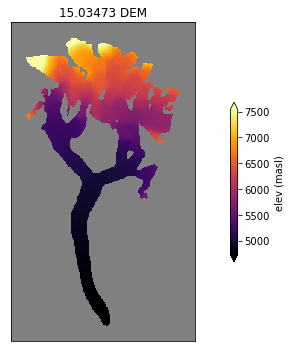

In [24]:
# for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
for nglac, glac_idx in enumerate(main_glac_rgi.index.values[[2306]]):
# for nglac, glac_idx in enumerate([main_glac_rgi.index.values[502]]):
# for nglac, glac_idx in enumerate([main_glac_rgi.index.values[0]]):
    glac_str = main_glac_rgi.loc[glac_idx,'rgino_str']
    rgiid = main_glac_rgi.loc[glac_idx,'RGIId']
    
    print(nglac, glac_idx, rgiid)
    
    out_csv_fn = os.path.join(input.mb_binned_fp, glac_str + csv_ending)
    if verbose:
        print('output_fn:', out_csv_fn)

    if not os.path.exists(out_csv_fn):
    
        region = glac_str.split('.')[0]
        
        # ===== Project shapefile =====
        huss_dir = input.huss_dir_sample.replace('XXXX',str(region.zfill(2)))
        huss_fn = input.huss_fn_sample.replace('XXXX',glac_str)

        proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
        ds = gdal.Open(proj_fn)
        prj = ds.GetProjection()
        srs = osr.SpatialReference(wkt=prj)
        aea_srs = srs
        
        # Shape layer processing
        # If projected shapefile already exists, then skip projection
        glac_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_crs' + 
                            str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
        dc_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                          str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
        if os.path.exists(glac_shp_proj_fn) == False:
            glac_shp_init = gpd.read_file(input.glac_shp_fn_dict[region])
            if verbose:
                print('Shp init crs:', glac_shp_init.crs)
            glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
            glac_shp_single = glac_shp_single.reset_index()
            glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            glac_shp_proj.to_file(glac_shp_proj_fn)

        if os.path.exists(dc_shp_proj_fn) == False:
            dc_shp_init = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
            dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
            dc_shp_single = dc_shp_single.reset_index()
            dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            dc_shp_proj.to_file(dc_shp_proj_fn)

        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        #This should be contained in features
        glac_shp_srs = glac_shp_lyr.GetSpatialRef()
        feat_count = glac_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count: %i" % feat_count)

        dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
        dc_shp_lyr = dc_shp_ds.GetLayer()
        #This should be contained in features
        dc_shp_srs = dc_shp_lyr.GetSpatialRef()
        feat_count = dc_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count (debris cover): %i" % feat_count)
            
        # Load DEM
        z1_dir = input.z1_dir_sample.replace('XXXX',str(region.zfill(2)))
        z1_fn = input.z1_fn_sample.replace('XXXX',glac_str)
        z1_ds = gdal.Open(z1_dir + z1_fn)
        z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

        glacname_fieldname = "Name"
        glacnum_fieldname = "RGIId"
        glacnum_fmt = '%08.5f'

        for n, feat in enumerate(glac_shp_lyr):
            gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
            if verbose:
                print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
            #NOTE: Input must be in projected coordinate system, ideally equal area
            #Should check this and reproject
            gf.geom_attributes(srs=aea_srs)

        if verbose:
            print(gf.feat_fn)
            
            
        fn_dict = OrderedDict()
        #We at least want to warp the two input DEMs
        fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

        if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
            if verbose:
                print(gf.glacnum)

            # Ice thickness data
            ice_thick_fn = os.path.join(huss_dir, huss_fn)
            if os.path.exists(ice_thick_fn):
                fn_dict['ice_thick'] = ice_thick_fn

            if os.path.exists(input.v_dir + input.vx_fn_dict[input.roi]):
                fn_dict['vx'] = input.v_dir + input.vx_fn_dict[input.roi]
                fn_dict['vy'] = input.v_dir + input.vy_fn_dict[input.roi]

            if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]


        #Expand extent to include buffered region around glacier polygon
        warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=input.buff_dist)
        if verbose:
            print("Expanding extent")
            print(gf.glac_geom_extent)
            print(warp_extent)
            print(aea_srs)
        
        #Warp everything to common res/extent/proj
        z1_gt = gdal.Open(fn_dict['z1']).GetGeoTransform()
        z1_res = np.min([z1_gt[1], -z1_gt[5]])
        ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                r='cubic')
        ds_dict = dict(zip(fn_dict.keys(), ds_list))

        if verbose:
            print(ds_list)
            print(fn_dict.keys())
            
        
        #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
        dc_shp_lyr = dc_shp_ds.GetLayer()

        #Get global glacier mask
        #Want this to be True over ALL glacier surfaces, not just the current polygon
        glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
        dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

        #Create buffer around glacier polygon
        glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

        # ds masks
        ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
        dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
        dems_mask = dem1.mask
        if verbose:
            print('list of datasets:', len(ds_list_masked), fn_dict.values())

        #Combine to identify ~1 km buffer around glacier polygon over static rock
        static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
        static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)
        
        if 'z1' in ds_dict:
            #This is False over glacier polygon surface, True elsewhere - can be applied directly
            glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
            gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
            #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

            # Debris cover
            dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
            gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)

            # Check if DEM has huge errors or not - replace if necessary
            if input.roi in ['01']:

                gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
                if gf.z1_check.min() < 0:

                    # Add backup DEM for regions with known poor quality (ex. Alaska)
                    print('switching DEMs')
                    fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
                    # Warp everything to common res/extent/proj (a second time)
                    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                            r='cubic')
                    ds_dict = dict(zip(fn_dict.keys(), ds_list))

                    if verbose:
                        print(ds_list)
                        print(fn_dict.keys())

                    # ds masks
                    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
                    dem1 = np.ma.masked_less_equal(ds_list_masked[-1], 0)
                    dems_mask = dem1.mask
                    if verbose:
                        print('list of datasets:', len(ds_list_masked), fn_dict.values())

                    #Combine to identify ~1 km buffer around glacier polygon over static rock
                    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
                    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

                    #This is False over glacier polygon surface, True elsewhere - can be applied directly
                    glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
                    gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
                    #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

                    # Debris cover
                    dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
                    gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)


            if verbose:
                print('\n\n# z1 pixels:', gf.z1.count(), '\n')
            if gf.z1.count() == 0:
                if verbose:
                    print("No z1 pixels")
        else:
            print("Unable to load z1 ds")
            
        # ===== ADD VARIOUS LAYERS TO gf =====
        if nglac == 0:
            print('\n\nHACK TO BYPASS VALID AREA\n\n')
        gf.valid_area_perc = 100

        if gf.valid_area_perc < (100. * input.min_valid_area_perc):
            if verbose:
                print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
        #     return None

        else:
            #Filter dz - throw out abs differences >150 m

            #Compute dz, volume change, mass balance and stats
            gf.z1_stats = malib.get_stats(gf.z1)
            z1_elev_med = gf.z1_stats[5]
            z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

            #Caluclate stats for aspect and slope using z2
            #Requires GDAL 2.1+
            gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
            gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
            z1_aspect_med = gf.z1_aspect_stats[5]
            gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
            gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
            z1_slope_med = gf.z1_slope_stats[5]

            #Can estimate ELA values computed from hypsometry and typical AAR
            #For now, assume ELA is mean
            gf.z1_ela = None
            gf.z1_ela = gf.z1_stats[3]
            #Note: in theory, the ELA should get higher with mass loss
            #In practice, using mean and same polygon, ELA gets lower as glacier surface thins

            # copy for Ts because it change the mask otherwise and messes up binned statistics for whole glacier
            glac_geom_mask_copy = glac_geom_mask.copy()
            
            if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
                if 'ice_thick' in ds_dict:
                    #Load ice thickness
                    gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                    gf.H_mean = gf.H.mean()
                    if verbose:
                        print('mean ice thickness [m]:', gf.H_mean)

                if 'vx' in ds_dict and 'vy' in ds_dict:
                    #Load surface velocity maps
                    gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                    gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
                    gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                    gf.vm_mean = gf.vm.mean()
                    if verbose:
                        print('mean velocity [m/s]:', gf.vm_mean)

                    if gf.H is not None:
                        #Compute flux
                        gf.Q = gf.H * input.v_col_f * np.array([gf.vx, gf.vy])
                        #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                        #Want x-derivative of x component
                        gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

        #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
        #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                        #Should smooth divQ, better handling of data gaps

                if 'ts' in ds_dict:
                    #Load surface temperature maps
                    gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask_copy)
                    gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                else:
                    gf.ts = None

                if 'debris_thick_ts' in ds_dict:
                    # Load debris thickness map
                    gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask_copy)
                    gf.meltfactor_ts = None
                else:
                    gf.debris_thick_ts = None
                    gf.meltfactor_ts = None

            gf.res = geolib.get_res(ds_dict['z1'])

            if verbose:
                print('Area [km2]:', gf.glac_area / 1e6)
                print('-------------------------------')
                
                
            gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
            
            # ===== DEM =====
            titles = [glac_str + ' DEM']
            var_full2plot = gf.z1.copy()
#                         var_full2plot.mask = gf.z1.mask
            clim = malib.calcperc(var_full2plot, (2,98))
            plot_array(var_full2plot, clim, titles, 'inferno', 'elev (masl)', 
                       close_fig=False)


#             # Plots
#     #         titles = ['Z1']
#     #         z1_full2plot = gf.z1
#     #         z1_full2plot.mask = dems_mask
#     #         clim = malib.calcperc(z1_full2plot, (2,98))
#     #         plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=input.output_fig_fp + glac_str + '_dem.png')

#             #Now apply glacier mask AND mask NaN values
#             glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
#             # nan_mask = np.ma.masked_invalid(gf.dz)
#             # glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
#             gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
            
# #             # Debris cover mask
# #             dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)

#             gf.res = geolib.get_res(ds_dict['z1'])

#             titles = ['Z1 (masked)']
#             clim = malib.calcperc(gf.z1, (2,98))
#             plot_array(gf.z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=input.output_fig_fp + glac_str + '_dem.png')

#             if verbose:
#                 print(gf.z1.shape)
                
# #             titles = ['Vx']
# #             var_full2plot = gf.vx
# #             var_full2plot.mask = glac_geom_mask
# #             clim = malib.calcperc(var_full2plot, (2,98))
# #             plot_array(var_full2plot, clim, titles, 'inferno', 'vx', fn=input.output_fig_fp + gf.feat_fn +'_vx.png')

# #             titles = ['Vy']
# #             var_full2plot = gf.vy
# #             var_full2plot.mask = glac_geom_mask
# #             clim = malib.calcperc(var_full2plot, (2,98))
# #             plot_array(var_full2plot, clim, titles, 'inferno', 'vy', fn=input.output_fig_fp + gf.feat_fn +'_vy.png')

#             gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

#             titles = ['Velocity (m/yr)']
#             var_full2plot = gf.vtot
#             var_full2plot.mask = glac_geom_mask
#             clim = malib.calcperc(var_full2plot, (2,98))
#             plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=input.output_fig_fp + glac_str +'_velocity.png',
#                        close_fig=close_fig)

#             titles = ['Ice thickness']
#             var_full2plot = gf.H
#             var_full2plot.mask = glac_geom_mask
# #             var_full2plot.mask = dc_mask
#             clim = malib.calcperc(var_full2plot, (2,98))
#             plot_array(var_full2plot, clim, titles, 'inferno', 'H', fn=input.output_fig_fp + gf.feat_fn +'_ice_thickness.png',
#                       close_fig=close_fig)
        
            
#             titles = ['Debris cover']
#             var_full2plot = gf.dc_area
#             clim = (0,1)
#             plot_array(var_full2plot, clim, titles, 'inferno', '', fn=input.output_fig_fp + gf.feat_fn +'_debriscover.png',
#                       close_fig=close_fig)
            
#             titles = ['Flux']
#             divQ_full2plot = gf.divQ
#             divQ_full2plot.mask = glac_geom_mask
#             clim = malib.calcperc(divQ_full2plot, (2,98))
#             plot_array(divQ_full2plot, clim, titles, 'inferno', 'divQ', fn=input.output_fig_fp + glac_str +'_divQ.png')

            # ===== "COREGISTER" SURFACE LOWERING WITH DEM USED FOR ICE THICKNESS =====
            # Load Mass Balance Data and find displacement =====
            if verbose:
                print('\nREALLY THIS SHOULD BE DONE BY COREGISTRATION OF THE TWO DEMS\n')
                print(main_glac_rgi.loc[glac_idx, 'mb_fn'])
            mb_df = pd.read_csv(main_glac_rgi.loc[glac_idx, 'mb_fn'])
            mb_df.loc[:,:] = mb_df.values.astype(np.float64)
            
            print(mb_df)
            
            try:
                mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_perc'] / 100 * main_glac_rgi.loc[glac_idx,'Area']
                print('here:', main_glac_rgi.loc[glac_idx,'Area'])
            except:
                mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_valid_km2']
                
            print('mb_bin0_km2:', mb_bin0_km2)
                
            mb_bin_size = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
            pix_km2 = gf.res[0] * gf.res[1] / (1000)**2
            if verbose:
                print('total glacier area [km2]:', main_glac_rgi.loc[glac_idx,'Area'])
                print('initial bin area [km2]:', mb_bin0_km2)
                print('bin size [m]:', mb_bin_size)
                print('pixel size [km2]:', pix_km2)
            # Find displacement
            if len(gf.z1.compressed()) > 0:
                z1 = gf.z1.compressed()
                z1_min = z1[z1>0].min()
                z1_max = z1[z1>0].max()
                z1_km2 = 0
                elev = int(z1_min)
                
                print('z1_min:', z1_min)
                
                while z1_km2 < mb_bin0_km2 and elev < z1_max:
                    elev += 1
                    z1_idx = np.where((z1 > 0) & (z1 < elev))
                    if len(z1_idx[0]) > 0:
                        z1_km2 = len(z1_idx[0]) * pix_km2
                        print(elev, z1_km2)        
                if verbose:
                    print(elev, z1_km2, 'vs', mb_df.loc[0,'# bin_center_elev_m'], mb_bin0_km2)
                mb_bin0_upper =  mb_df.loc[0,'# bin_center_elev_m'] + mb_bin_size / 2
                z1_offset = elev - mb_bin0_upper
                if verbose:
                    print('z1_offset:', z1_offset)
                # Update z1 with the offset
                mask_offset = np.ma.array(np.zeros(gf.z1.mask.shape) - z1_offset, mask=np.ma.getmask(gf.z1))
                gf.z1[~gf.z1.mask] = gf.z1[~gf.z1.mask] + mask_offset[~mask_offset.mask]
                
                mask_offset_dc = np.ma.array(np.zeros(gf.dc_area.mask.shape) - z1_offset, mask=np.ma.getmask(gf.dc_area))
                gf.dc_area[~gf.dc_area.mask] = gf.dc_area[~gf.dc_area.mask] + mask_offset[~mask_offset_dc.mask]

# #                 # ===== EMERGENCE VELOCITY =====
# #                 vx = np.ma.filled(gf.vx,0)
# #                 vy = np.ma.filled(gf.vy,0)
# #                 H = np.ma.filled(gf.H,0)
# #                 vx[gf.z1 > gf.z1.max()] = 0
# #                 vy[gf.z1 > gf.z1.max()] = 0
# #                 H[gf.z1 > gf.z1.max()] = 0
# #                 vmax = np.nanmax((vx**2 + vy**2)**0.5)

# #                 # Emergence computation
# #                 emvel = emergence_pixels(gf, vx, vy, H, gf.res[0], gf.res[1], 
# #                                          positive_is_east=True, positive_is_north=True, 
# #                                          constant_icethickness=False, max_velocity=vmax, vel_min=0, debug=False)
# #                 # 3x3 filter to reduce
# #                 if input.emvel_filter_pixsize > 0:
# #                     emvel = ndimage.filters.convolve(emvel, weights=np.full((input.emvel_filter_pixsize, input.emvel_filter_pixsize), 
# #                                                                             1.0/input.emvel_filter_pixsize**2))
# #                 # Add to glacier feature
# #                 gf.emvel = np.ma.masked_array(emvel, mask=np.ma.getmask(gf.z1))

# #                 # ===== EXPORT BINNED STATISTICS =====
# #                 #Do AED for all
# #                 #Compute mb using scaled AED vs. polygon
# #                 #Check for valid pixel count vs. feature area, fill if appropriate
# #                 if gf.glac_area_km2 > input.min_glac_area_writeout:
# #                     outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, csv_ending=csv_ending,
# #                                                         mb_df=mb_df)

# # #                     if verbose:
# # #                         print(outbins_df.loc[0:10,['bin_center_elev_m', ' vm_med',' vm_mad', ' H_mean', ' H_std', 
# # #                                                    ' emvel_mean', ' emvel_std',' emvel_med', ' emvel_mad']])
# #             else:
# #                 print('\n' + glac_str + ' HAS NO GLACIER AREA!\n')
mb_df

In [28]:
mb_df = mb_df.rename(columns={'# bin_center_elev_m':'bin_center_elev_m'})
mb_df

,bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc,z2_bin_count_valid,z2_bin_area_valid_km2,z2_bin_area_perc,dhdt_bin_count,dhdt_bin_area_valid_km2,dhdt_bin_area_perc,...,perc_debris,perc_pond,perc_clean,dhdt_debris_med,dhdt_pond_med,dhdt_clean_med,vm_med,vm_mad,H_mean,H_std
0,4675.0,1459.0,1.313,2.15,1910.0,1.719,2.15,1459.0,1.313,2.15,...,82.31,17.69,0.00,-0.29,-0.56,NaN,0.80,0.32,87.70,30.50
1,4725.0,1885.0,1.696,2.78,1964.0,1.768,2.78,1885.0,1.696,2.78,...,96.37,3.63,0.00,-0.47,-1.42,NaN,1.91,0.72,101.80,33.72
2,4775.0,1561.0,1.405,2.30,1476.0,1.328,2.30,1561.0,1.405,2.30,...,98.58,1.42,0.00,-0.76,-1.13,NaN,2.93,0.91,121.81,41.47
3,4825.0,1862.0,1.676,2.74,1881.0,1.693,2.74,1862.0,1.676,2.74,...,97.46,2.49,0.05,-0.83,-1.27,NaN,4.77,1.89,149.96,53.22
4,4875.0,1637.0,1.473,2.41,1690.0,1.521,2.41,1637.0,1.473,2.41,...,98.89,1.11,0.00,-0.83,-1.44,NaN,9.26,2.55,154.75,43.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,7975.0,64.0,0.058,0.09,56.0,0.050,0.09,64.0,0.058,0.09,...,0.00,0.00,100.00,NaN,NaN,0.10,0.85,0.24,33.36,7.16
67,8025.0,83.0,0.075,0.12,78.0,0.070,0.12,83.0,0.075,0.12,...,2.47,0.00,97.53,NaN,NaN,0.37,0.45,0.15,29.07,9.54
68,8075.0,111.0,0.100,0.16,116.0,0.104,0.16,111.0,0.100,0.16,...,0.00,0.00,100.00,NaN,NaN,0.14,0.26,0.14,26.46,9.96
69,8125.0,159.0,0.143,0.23,163.0,0.147,0.23,159.0,0.143,0.23,...,0.00,0.00,100.00,NaN,NaN,0.11,0.41,0.12,23.56,9.37


0 2306 RGI60-15.03473
output_fn: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../output/mb_bins/csv/15.03473_mb_bins_wdc_emvel_offset.csv
Shp init crs: {'init': 'epsg:4326'}
Input glacier polygon count: 1
Input glacier polygon count (debris cover): 1
1 of 1: 15.03473
15.03473
15.03473
/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../../../HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/RGI60-15.03473_thickness.tif
Expanding extent
[466274.413315571, 3090038.90589917, 476685.521575542, 3109419.82835597]
[465274.413315571, 3089038.90589917, 477685.521575542, 3110419.82835597]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNI

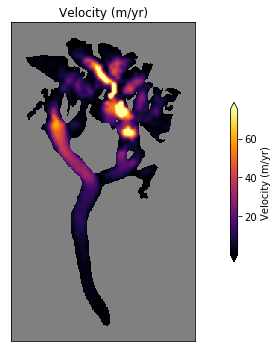

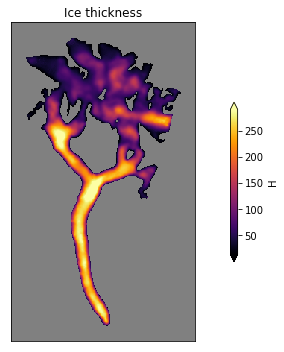

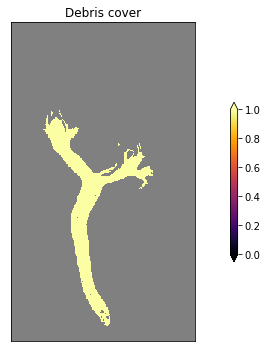

In [13]:
# # for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
# for nglac, glac_idx in enumerate(main_glac_rgi.index.values[[2306]]):
# # for nglac, glac_idx in enumerate([main_glac_rgi.index.values[502]]):
# # for nglac, glac_idx in enumerate([main_glac_rgi.index.values[0]]):
#     glac_str = main_glac_rgi.loc[glac_idx,'rgino_str']
#     rgiid = main_glac_rgi.loc[glac_idx,'RGIId']
    
#     print(nglac, glac_idx, rgiid)
    
#     out_csv_fn = os.path.join(input.mb_binned_fp, glac_str + csv_ending)
#     if verbose:
#         print('output_fn:', out_csv_fn)

#     if not os.path.exists(out_csv_fn):
    
#         region = glac_str.split('.')[0]

#         # Shape layer processing
#         glac_shp_init = gpd.read_file(input.glac_shp_fn_dict[region])
#         dc_shp_init = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
#         if verbose:
#             print('Shp init crs:', glac_shp_init.crs)

#         glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
#         glac_shp_single = glac_shp_single.reset_index()
#         dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
#         dc_shp_single = dc_shp_single.reset_index()

#         # Project shapefile
#         huss_dir = input.huss_dir_sample.replace('XXXX',str(region.zfill(2)))
#         huss_fn = input.huss_fn_sample.replace('XXXX',glac_str)

#         proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
#         ds = gdal.Open(proj_fn)
#         prj = ds.GetProjection()
#         srs = osr.SpatialReference(wkt=prj)
#         aea_srs = srs

#         # If projected shapefile already exists, then skip projection
#         glac_shp_proj_fn = input.glac_shp_proj_fp + glac_str + '_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'
#         dc_shp_proj_fn = input.glac_shp_proj_fp + glac_str + '_dc_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'

#         if os.path.exists(glac_shp_proj_fn) == False:
#             glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
#             glac_shp_proj.to_file(glac_shp_proj_fn)
            
#         if os.path.exists(dc_shp_proj_fn) == False:
#             dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
#             dc_shp_proj.to_file(dc_shp_proj_fn)
        

#         glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
#         glac_shp_lyr = glac_shp_ds.GetLayer()
#         #This should be contained in features
#         glac_shp_srs = glac_shp_lyr.GetSpatialRef()
#         feat_count = glac_shp_lyr.GetFeatureCount()
#         if verbose:
#             print("Input glacier polygon count: %i" % feat_count)
            
#         dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
#         dc_shp_lyr = dc_shp_ds.GetLayer()
#         #This should be contained in features
#         dc_shp_srs = dc_shp_lyr.GetSpatialRef()
#         feat_count = dc_shp_lyr.GetFeatureCount()
#         if verbose:
#             print("Input glacier polygon count (debris cover): %i" % feat_count)

#         # Load DEM
#         z1_dir = input.z1_dir_sample.replace('XXXX',str(region.zfill(2)))
#         z1_fn = input.z1_fn_sample.replace('XXXX',glac_str)
#         z1_ds = gdal.Open(z1_dir + z1_fn)
#         z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

#         glacfeat_list = []
#         glacname_fieldname = "Name"
#         #RGIId (String) = RGI50-01.00004
#         glacnum_fieldname = "RGIId"
#         glacnum_fmt = '%08.5f'

#         for n, feat in enumerate(glac_shp_lyr):
#             gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
#             if verbose:
#                 print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
#             #NOTE: Input must be in projected coordinate system, ideally equal area
#             #Should check this and reproject
#             gf.geom_attributes(srs=aea_srs)
#             glacfeat_list.append(gf)

#         if verbose:
#             print(gf.feat_fn)
        
#         fn_dict = OrderedDict()
#         #We at least want to warp the two input DEMs
#         fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

#         if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
#             if verbose:
#                 print(gf.glacnum)

#             # Ice thickness data
#             ice_thick_fn = os.path.join(huss_dir, huss_fn)
#             if os.path.exists(ice_thick_fn):
#                 fn_dict['ice_thick'] = ice_thick_fn

#             if verbose:
#                 print(fn_dict['ice_thick'])

#             # Surface velocity
#             if os.path.exists(input.v_dir + input.vx_fn_dict[input.roi]):
#                 fn_dict['vx'] = input.v_dir + input.vx_fn_dict[input.roi]
#                 fn_dict['vy'] = input.v_dir + input.vy_fn_dict[input.roi]
                

#     #         if os.path.exists(ts_fullfn):
#     #             fn_dict['ts'] = ts_fullfn

#     #         if os.path.exists(debris_fullfn):
#     #             fn_dict['debris_thick_ts'] = debris_fullfn

#         #Expand extent to include buffered region around glacier polygon
#         warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=input.buff_dist)
#         if verbose:
#             print("Expanding extent")
#             print(gf.glac_geom_extent)
#             print(warp_extent)
#             print(aea_srs)

#         #Warp everything to common res/extent/proj
#         ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
#                 extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#                 r='cubic')

#         ds_dict = dict(zip(fn_dict.keys(), ds_list))

#         if verbose:
#             print(ds_list)
#             print(fn_dict.keys())

#         #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
#         glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
#         glac_shp_lyr = glac_shp_ds.GetLayer()
        
#         dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
#         dc_shp_lyr = dc_shp_ds.GetLayer()

#         #Get global glacier mask
#         #Want this to be True over ALL glacier surfaces, not just the current polygon
#         glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
#         dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

#         #Create buffer around glacier polygon
#         glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
#         #This is False over glacier polygon surface, True elsewhere - can be applied directly
#         glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

#         # ds masks
#         ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#         dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
#         dems_mask = dem1.mask
#         if verbose:
#             print('list of datasets:', len(ds_list_masked), fn_dict.values())

#         #Combine to identify ~1 km buffer around glacier polygon over static rock
#         static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#         static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)
        
#         if 'z1' in ds_dict:
#             #This is False over glacier polygon surface, True elsewhere - can be applied directly
#             glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
#             gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
#             #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
            
#             # Debris cover
#             dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
#             gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)

#             # Check if DEM has huge errors or not - replace if necessary
#             if input.roi in ['01']:
                
#                 gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
#                 if gf.z1_check.min() < 0:
                    
#                     # Add backup DEM for regions with known poor quality (ex. Alaska)
#                     print('switching DEMs')
#                     fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
#                     # Warp everything to common res/extent/proj (a second time)
#                     ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
#                             extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#                             r='cubic')
#                     ds_dict = dict(zip(fn_dict.keys(), ds_list))
# #                     glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
# #                     gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']))
                    
# #                     # Debris cover
# #                     dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
# #                     gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)
                    
#                     if verbose:
#                         print(ds_list)
#                         print(fn_dict.keys())

#                     #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
#                     glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
#                     glac_shp_lyr = glac_shp_ds.GetLayer()

#                     dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
#                     dc_shp_lyr = dc_shp_ds.GetLayer()

#                     #Get global glacier mask
#                     #Want this to be True over ALL glacier surfaces, not just the current polygon
#                     glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
#                     dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

#                     #Create buffer around glacier polygon
#                     glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
#                     #This is False over glacier polygon surface, True elsewhere - can be applied directly
#                     glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

#                     # ds masks
#                     ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#                     dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
#                     dems_mask = dem1.mask
#                     if verbose:
#                         print('list of datasets:', len(ds_list_masked), fn_dict.values())

#                     #Combine to identify ~1 km buffer around glacier polygon over static rock
#                     static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#                     static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)
                    
#                     #This is False over glacier polygon surface, True elsewhere - can be applied directly
#                     glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
#                     gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
#                     #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

#                     # Debris cover
#                     dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
#                     gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)


#             if verbose:
#                 print('\n\n# z1 pixels:', gf.z1.count(), '\n')
#             if gf.z1.count() == 0:
#                 if verbose:
#                     print("No z1 pixels")
            
#         else:
#             print("Unable to load z1 ds")
            
        
        
#         if nglac == 0:
#             print('\n\nHACK TO BYPASS VALID AREA\n\n')
#         gf.valid_area_perc = 100

#         if gf.valid_area_perc < (100. * input.min_valid_area_perc):
#             if verbose:
#                 print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#         #     return None

#         else:
#             #Filter dz - throw out abs differences >150 m

#             #Compute dz, volume change, mass balance and stats
#             gf.z1_stats = malib.get_stats(gf.z1)
#             z1_elev_med = gf.z1_stats[5]
#             z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

#             #Caluclate stats for aspect and slope using z2
#             #Requires GDAL 2.1+
#             gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
#             gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
#             z1_aspect_med = gf.z1_aspect_stats[5]
#             gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
#             gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
#             z1_slope_med = gf.z1_slope_stats[5]

#             #Can estimate ELA values computed from hypsometry and typical AAR
#             #For now, assume ELA is mean
#             gf.z1_ela = None
#             gf.z1_ela = gf.z1_stats[3]
#             #Note: in theory, the ELA should get higher with mass loss
#             #In practice, using mean and same polygon, ELA gets lower as glacier surface thins

#             if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
#                 if 'ice_thick' in ds_dict:
#                     #Load ice thickness
#                     gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
#                     gf.H_mean = gf.H.mean()
#                     if verbose:
#                         print('mean ice thickness [m]:', gf.H_mean)

#                 if 'vx' in ds_dict and 'vy' in ds_dict:
#                     #Load surface velocity maps
#                     gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
#                     gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
#                     gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
#                     gf.vm_mean = gf.vm.mean()
#                     if verbose:
#                         print('mean velocity [m/s]:', gf.vm_mean)

#                     if gf.H is not None:
#                         #Compute flux
#                         gf.Q = gf.H * input.v_col_f * np.array([gf.vx, gf.vy])
#                         #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
#                         #Want x-derivative of x component
#                         gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

#         #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
#         #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

#                         #Should smooth divQ, better handling of data gaps
                

#                 if 'ts' in ds_dict:
#                     #Load surface temperature maps
#                     gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
#                 else:
#                     gf.ts = None

#                 if 'debris_thick_ts' in ds_dict:
#                     # Load debris thickness map
#                     gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
#                     gf.meltfactor_ts = None
#                 else:
#                     gf.debris_thick_ts = None
#                     gf.meltfactor_ts = None

#             if verbose:
#                 print('Area [km2]:', gf.glac_area / 1e6)
#                 print('-------------------------------')


#             # Plots
#     #         titles = ['Z1']
#     #         z1_full2plot = gf.z1
#     #         z1_full2plot.mask = dems_mask
#     #         clim = malib.calcperc(z1_full2plot, (2,98))
#     #         plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=input.output_fig_fp + glac_str + '_dem.png')

#             #Now apply glacier mask AND mask NaN values
#             glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
#             # nan_mask = np.ma.masked_invalid(gf.dz)
#             # glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
#             gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
            
# #             # Debris cover mask
# #             dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)

#             gf.res = geolib.get_res(ds_dict['z1'])

#             titles = ['Z1 (masked)']
#             clim = malib.calcperc(gf.z1, (2,98))
#             plot_array(gf.z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=input.output_fig_fp + glac_str + '_dem.png')

#             if verbose:
#                 print(gf.z1.shape)
                
# #             titles = ['Vx']
# #             var_full2plot = gf.vx
# #             var_full2plot.mask = glac_geom_mask
# #             clim = malib.calcperc(var_full2plot, (2,98))
# #             plot_array(var_full2plot, clim, titles, 'inferno', 'vx', fn=input.output_fig_fp + gf.feat_fn +'_vx.png')

# #             titles = ['Vy']
# #             var_full2plot = gf.vy
# #             var_full2plot.mask = glac_geom_mask
# #             clim = malib.calcperc(var_full2plot, (2,98))
# #             plot_array(var_full2plot, clim, titles, 'inferno', 'vy', fn=input.output_fig_fp + gf.feat_fn +'_vy.png')

#             gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

#             titles = ['Velocity (m/yr)']
#             var_full2plot = gf.vtot
#             var_full2plot.mask = glac_geom_mask
#             clim = malib.calcperc(var_full2plot, (2,98))
#             plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=input.output_fig_fp + glac_str +'_velocity.png',
#                        close_fig=close_fig)

#             titles = ['Ice thickness']
#             var_full2plot = gf.H
#             var_full2plot.mask = glac_geom_mask
# #             var_full2plot.mask = dc_mask
#             clim = malib.calcperc(var_full2plot, (2,98))
#             plot_array(var_full2plot, clim, titles, 'inferno', 'H', fn=input.output_fig_fp + gf.feat_fn +'_ice_thickness.png',
#                       close_fig=close_fig)
        
            
#             titles = ['Debris cover']
#             var_full2plot = gf.dc_area
#             clim = (0,1)
#             plot_array(var_full2plot, clim, titles, 'inferno', '', fn=input.output_fig_fp + gf.feat_fn +'_debriscover.png',
#                       close_fig=close_fig)
            
#             titles = ['Flux']
#             divQ_full2plot = gf.divQ
#             divQ_full2plot.mask = glac_geom_mask
#             clim = malib.calcperc(divQ_full2plot, (2,98))
#             plot_array(divQ_full2plot, clim, titles, 'inferno', 'divQ', fn=input.output_fig_fp + glac_str +'_divQ.png')

#             # ===== "COREGISTER" SURFACE LOWERING WITH DEM USED FOR ICE THICKNESS =====
#             # Load Mass Balance Data and find displacement =====
#             if verbose:
#                 print('\nREALLY THIS SHOULD BE DONE BY COREGISTRATION OF THE TWO DEMS\n')
#             mb_df = pd.read_csv(main_glac_rgi.loc[glac_idx, 'mb_fn'])
#             mb_df.loc[:,:] = mb_df.values.astype(np.float64)
#             try:
#                 mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_perc'] / 100 * main_glac_rgi.loc[glac_idx,'Area']
#             except:
#                 mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_valid_km2']
#             mb_bin_size = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
#             pix_km2 = gf.res[0] * gf.res[1] / (1000)**2
#             if verbose:
#                 print('total glacier area [km2]:', main_glac_rgi.loc[glac_idx,'Area'])
#                 print('initial bin area [km2]:', mb_bin0_km2)
#                 print('bin size [m]:', mb_bin_size)
#                 print('pixel size [km2]:', pix_km2)
#             # Find displacement
#             if len(gf.z1.compressed()) > 0:
#                 z1 = gf.z1.compressed()
#                 z1_min = z1[z1>0].min()
#                 z1_max = z1[z1>0].max()
#                 z1_km2 = 0
#                 elev = int(z1_min)
#                 while z1_km2 < mb_bin0_km2 and elev < z1_max:
#                     elev += 1
#                     z1_idx = np.where((z1 > 0) & (z1 < elev))
#                     if len(z1_idx[0]) > 0:
#                         z1_km2 = len(z1_idx[0]) * pix_km2
# #                         print(elev, z1_km2)        
#                 if verbose:
#                     print(elev, z1_km2, 'vs', mb_df.loc[0,'# bin_center_elev_m'], mb_bin0_km2)
#                 mb_bin0_upper =  mb_df.loc[0,'# bin_center_elev_m'] + mb_bin_size / 2
#                 z1_offset = elev - mb_bin0_upper
#                 if verbose:
#                     print('z1_offset:', z1_offset)
#                 # Update z1 with the offset
#                 mask_offset = np.ma.array(np.zeros(gf.z1.mask.shape) - z1_offset, mask=np.ma.getmask(gf.z1))
#                 gf.z1[~gf.z1.mask] = gf.z1[~gf.z1.mask] + mask_offset[~mask_offset.mask]
                
#                 mask_offset_dc = np.ma.array(np.zeros(gf.dc_area.mask.shape) - z1_offset, mask=np.ma.getmask(gf.dc_area))
#                 gf.dc_area[~gf.dc_area.mask] = gf.dc_area[~gf.dc_area.mask] + mask_offset[~mask_offset_dc.mask]

# #                 # ===== EMERGENCE VELOCITY =====
# #                 vx = np.ma.filled(gf.vx,0)
# #                 vy = np.ma.filled(gf.vy,0)
# #                 H = np.ma.filled(gf.H,0)
# #                 vx[gf.z1 > gf.z1.max()] = 0
# #                 vy[gf.z1 > gf.z1.max()] = 0
# #                 H[gf.z1 > gf.z1.max()] = 0
# #                 vmax = np.nanmax((vx**2 + vy**2)**0.5)

# #                 # Emergence computation
# #                 emvel = emergence_pixels(gf, vx, vy, H, gf.res[0], gf.res[1], 
# #                                          positive_is_east=True, positive_is_north=True, 
# #                                          constant_icethickness=False, max_velocity=vmax, vel_min=0, debug=False)
# #                 # 3x3 filter to reduce
# #                 if input.emvel_filter_pixsize > 0:
# #                     emvel = ndimage.filters.convolve(emvel, weights=np.full((input.emvel_filter_pixsize, input.emvel_filter_pixsize), 
# #                                                                             1.0/input.emvel_filter_pixsize**2))
# #                 # Add to glacier feature
# #                 gf.emvel = np.ma.masked_array(emvel, mask=np.ma.getmask(gf.z1))

# #                 # ===== EXPORT BINNED STATISTICS =====
# #                 #Do AED for all
# #                 #Compute mb using scaled AED vs. polygon
# #                 #Check for valid pixel count vs. feature area, fill if appropriate
# #                 if gf.glac_area_km2 > input.min_glac_area_writeout:
# #                     outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, csv_ending=csv_ending,
# #                                                         mb_df=mb_df)

# # #                     if verbose:
# # #                         print(outbins_df.loc[0:10,['bin_center_elev_m', ' vm_med',' vm_mad', ' H_mean', ' H_std', 
# # #                                                    ' emvel_mean', ' emvel_std',' emvel_med', ' emvel_mad']])
# #             else:
# #                 print('\n' + glac_str + ' HAS NO GLACIER AREA!\n')

In [ ]:
print('\n\n\nDONE\n\n\n')

In [14]:
# ===== DEBRIS ELEVATION STATS ====================================================================================
# Glaciers with data
glac_wobs_fns = []
rgiid_wobs = []
for i in os.listdir(input.mb_binned_fp):
    if i.endswith('_mb_bins_wdc_emvel_offset.csv'):
        rgiid_reg = int(i.split('.')[0])
        if int(rgiid_reg) in input.roi_rgidict[input.roi]:
            glac_wobs_fns.append(i)
            if rgiid_reg < 10:
                rgiid_wobs.append(i[0:7])
            else:
                rgiid_wobs.append(i[0:8])
        
glac_wobs_fns = sorted(glac_wobs_fns)
rgiid_wobs = sorted(rgiid_wobs)

# ===== SELECT GLACIERS WITH DATA =====
main_glac_rgi_wobs = input.selectglaciersrgitable(rgiid_wobs)
main_glac_rgi_wobs['mb_bin_fn'] = glac_wobs_fns 
main_glac_rgi_wobs['CenLon_360'] = main_glac_rgi_wobs['CenLon']
main_glac_rgi_wobs.loc[main_glac_rgi_wobs['CenLon_360'] < 0, 'CenLon_360'] = (
    360 + main_glac_rgi_wobs.loc[main_glac_rgi_wobs['CenLon_360'] < 0, 'CenLon_360'])
ds = xr.open_dataset(input.metdata_fp + '../' + input.metdata_elev_fn)
#  argmin() finds the minimum distance between the glacier lat/lon and the GCM pixel
lat_nearidx = (np.abs(main_glac_rgi_wobs['CenLat'].values[:,np.newaxis] - 
                      ds['latitude'][:].values).argmin(axis=1))
lon_nearidx = (np.abs(main_glac_rgi_wobs['CenLon_360'].values[:,np.newaxis] - 
                      ds['longitude'][:].values).argmin(axis=1))
latlon_nearidx = list(zip(lat_nearidx, lon_nearidx))
latlon_nearidx_unique = sorted(list(set(latlon_nearidx)))
main_glac_rgi_wobs['latlon_nearidx'] = latlon_nearidx
latlon_unique_dict = dict(zip(latlon_nearidx_unique,np.arange(0,len(latlon_nearidx_unique))))
latlon_unique_dict_reversed = dict(zip(np.arange(0,len(latlon_nearidx_unique)),latlon_nearidx_unique))
main_glac_rgi_wobs['latlon_unique_no'] = main_glac_rgi_wobs['latlon_nearidx'].map(latlon_unique_dict)

print('unique lat/lons:', len(np.unique(main_glac_rgi_wobs['latlon_unique_no'])), '\n\n')
# print(dc_shp_subset_wdata.loc[0:5,['RGIId', 'CenLat', 'CenLon', 'larsen_fn', 'braun_fn', 'latlon_unique_no']])

lat_list = np.array([ds.latitude[x[0]].values for x in latlon_nearidx_unique])
lon_list = np.array([ds.longitude[x[1]].values for x in latlon_nearidx_unique])
latlon_list = list(tuple(zip(list(lat_list), list(lon_list))))

# ===== CALCULATE DEBRIS ELEVATION STATS FOR GLACIERS WITH DATA FOR EACH UNIQUE LAT/LON ======
elev_stats_latlon_dict = {}
latlon_list_updated = []
for nlatlon, latlon_unique in enumerate(np.unique(main_glac_rgi_wobs.latlon_unique_no)):
# for nlatlon, latlon_unique in enumerate([np.unique(main_glac_rgi_wobs.latlon_unique_no)[6]]):

    main_glac_rgi_subset = main_glac_rgi_wobs[main_glac_rgi_wobs['latlon_unique_no'] == latlon_unique]
    
    # Debris elevation stats should be done by lat/lon
    df_all = None
    elev_list_all = []
    df_idx_count = 0
    for nglac, glac_fn in enumerate(main_glac_rgi_subset.mb_bin_fn.values):
        df_raw = pd.read_csv(input.mb_binned_fp + glac_fn)
        df = df_raw.dropna(subset=[' mb_bin_mean_mwea'])
        df_debris = df[(df[' vm_med'] < input.vel_threshold) & (df['debris_perc'] > input.debrisperc_threshold)
                       & (df[' dc_bin_count_valid'] > 0)]

        df_idx = df_debris.index.values
        df_idx_count += len(df_idx)
        
        if len(df_idx) > 0:
            # only work with terminus
            df_idx_dif = list(df_idx[1:] - df_idx[:-1])
            if np.sum(df_idx_dif) == len(df_idx)-1:
                df_idx_nojump = df_idx
            else:
                idx_jumpinbins = df_idx_dif.index(next(filter(lambda x: x>1, df_idx_dif)))
                df_idx_nojump = df_idx[0:idx_jumpinbins+1]

            df_debris_nojump = df_debris.loc[df_idx_nojump,:]
            df_debris_nojump.reset_index(inplace=True, drop=True)
            
            for nelev, elev in enumerate(list(df_debris_nojump['bin_center_elev_m'].values)):
                elev_list_single = list(np.repeat(elev, df_debris_nojump.loc[nelev,' dc_bin_count_valid']))
                elev_list_all.extend(elev_list_single)
        
    if df_idx_count > 0:
        dc_zmean = np.mean(elev_list_all)
        dc_zstd = np.std(elev_list_all)
        dc_zmed = malib.fast_median(elev_list_all)
        dc_zmad = malib.mad(elev_list_all)

        lat_deg = float(ds.latitude[latlon_unique_dict_reversed[latlon_unique][0]].values)
        lon_deg = float(ds.longitude[latlon_unique_dict_reversed[latlon_unique][1]].values)
        elev_stats_latlon_dict[lat_deg,lon_deg] = [dc_zmean, dc_zstd, dc_zmed, dc_zmad]
        latlon_list_updated.append((lat_deg, lon_deg))

# Update pickle of unique lat/lons that will be used for melt model
with open(input.latlon_unique_fp + input.latlon_unique_dict[input.roi], 'wb') as f:
    pickle.dump(latlon_list_updated, f)

791 glaciers in region 1 are included in this model run: ['00013', '00021', '00037', '00041', '00042', '00556', '00570', '00571', '00660', '00670', '00675', '00688', '00703', '00704', '00709', '00732', '00739', '00746', '00780', '00787', '00792', '00799', '00814', '00852', '00865', '00870', '00871', '00903', '00942', '00951', '00960', '00962', '00982', '01050', '01077', '01104', '01150', '01153', '01162', '01182', '01223', '01242', '01268', '01275', '01276', '01277', '01282', '01284', '01292', '01306'] and more
This study is focusing on 791 glaciers in region [1]
unique lat/lons: 277 




In [20]:
# ===== ADD DEBRIS ELEVATION STATS TO MET DATA ======
for nlatlon, latlon in enumerate(latlon_list_updated):
# for nlatlon, latlon in enumerate([latlon_list_updated[0]]):
    
    lat_deg = latlon[0]
    lon_deg = latlon[1]
    
#     print(lat_deg, lon_deg)

    # ===== Meteorological data =====
    metdata_fn = input.metdata_fn_sample.replace('XXXX', 
                                                 str(int(lat_deg*100)) + 'N-' + str(int(lon_deg*100)) + 'E-')
    
    ds = xr.open_dataset(input.metdata_fp + metdata_fn)
    if 'dc_zmean' not in list(ds.keys()):
        # Add stats
        ds['dc_zmean'] = elev_stats_latlon_dict[latlon][0]
        ds['dc_zmean'].attrs = {'units':'m a.s.l.', 'long_name':'Mean debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
        ds['dc_zstd'] = elev_stats_latlon_dict[latlon][1]
        ds['dc_zstd'].attrs = {'units':'m a.s.l.', 'long_name':'Standard deviation of debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
        ds['dc_zmed'] = elev_stats_latlon_dict[latlon][2]
        ds['dc_zmed'].attrs = {'units':'m a.s.l.', 'long_name':'Median debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
        ds['dc_zmad'] = elev_stats_latlon_dict[latlon][3]
        ds['dc_zmad'].attrs = {'units':'m a.s.l.', 'long_name':'Median absolute deviation of debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}

        try:
            ds.close()
        except:
            continue

        # Export updated dataset
#         ds.to_netcdf(input.metdata_fp + '../HMA_modified/' + metdata_fn)
        ds.to_netcdf(input.metdata_fp + metdata_fn, mode='a')
    else:
        print(lat_deg, lon_deg, 'exists')

In [13]:
print('TO-DO LIST:')
print('- Isolate the debris-covered areas for dh/dt (add as separate column to have the option)')
print('  --> requires the raw dh/dt grids for the region (ex. dont have for Larsen)')

TO-DO LIST:
- Isolate the debris-covered areas for dh/dt (add as separate column to have the option)
  --> requires the raw dh/dt grids for the region (ex. dont have for Larsen)


In [ ]:
# rgiid_list = []
# rgiid_fn_list = []
# for i in os.listdir(outdir):
#     if i.endswith('mb_bins.csv'):
#         rgiid_list.append(i[0:8])
#         rgiid_fn_list.append(i)
        
# rgiid_list = sorted(rgiid_list)
# rgiid_fn_list = sorted(rgiid_fn_list)

# print(len(rgiid_list))

# main_glac_rgi = selectglaciersrgitable(rgiid_list)
# main_glac_rgi['bin_fn'] = rgiid_fn_list

In [ ]:
# print(main_glac_rgi)

In [10]:
# # Group datasets by nearest lat/lon
# ds = xr.open_dataset(met_sample_fullfn)
# #  argmin() finds the minimum distance between the glacier lat/lon and the GCM pixel
# lat_nearidx = (np.abs(main_glac_rgi['CenLat'].values[:,np.newaxis] - 
#                       ds['latitude'][:].values).argmin(axis=1))
# lon_nearidx = (np.abs(main_glac_rgi['CenLon'].values[:,np.newaxis] - 
#                       ds['longitude'][:].values).argmin(axis=1))

# latlon_nearidx = list(zip(lat_nearidx, lon_nearidx))
# latlon_nearidx_unique = sorted(list(set(latlon_nearidx)))

# main_glac_rgi['latlon_nearidx'] = latlon_nearidx
# latlon_unique_dict = dict(zip(latlon_nearidx_unique,np.arange(0,len(latlon_nearidx_unique))))
# latlon_unique_dict_reversed = dict(zip(np.arange(0,len(latlon_nearidx_unique)),latlon_nearidx_unique))
# main_glac_rgi['latlon_unique_no'] = main_glac_rgi['latlon_nearidx'].map(latlon_unique_dict)
# print(main_glac_rgi)

In [12]:
# # Process each group and derive elevation statistics for the debris cover
# elevstats_mean = np.zeros((len(ds.latitude.values), len(ds.longitude.values)))
# elevstats_std = np.zeros((len(ds.latitude.values), len(ds.longitude.values)))
# elevstats_med = np.zeros((len(ds.latitude.values), len(ds.longitude.values)))
# elevstats_mad = np.zeros((len(ds.latitude.values), len(ds.longitude.values)))
# elevstats_min = np.zeros((len(ds.latitude.values), len(ds.longitude.values)))
# elevstats_max = np.zeros((len(ds.latitude.values), len(ds.longitude.values)))

# for nlatlon, latlon_idx in enumerate(list(np.arange(0,len(latlon_nearidx_unique)))):
# # for nlatlon, latlon_idx in enumerate([251]):
#     main_glac_rgi_subset = main_glac_rgi[main_glac_rgi['latlon_unique_no'] == latlon_idx]
#     bin_fns = main_glac_rgi_subset['bin_fn'].values
    
#     lat_idx, lon_idx = latlon_unique_dict_reversed[latlon_idx]
#     print(nlatlon, lat_idx, lon_idx)

#     df_all = None
#     for n, i in enumerate(bin_fns):
#         df = pd.read_csv(outdir + i)
        
# #         print(i)
        
#         # Process only glaciers with debris
#         debris_switch=False
#         if ' perc_debris' in df.columns:
#             # Process dataframe
#             output_cns = ['# bin_center_elev_m', ' z1_bin_area_valid_km2', ' perc_debris']
#             df = df[output_cns]
#             df['# bin_center_elev_m'] = df['# bin_center_elev_m'].astype(np.float) 
#             df[' z1_bin_area_valid_km2'] = df[' z1_bin_area_valid_km2'].astype(np.float)
            
#             # Remove nan values
#             df[' perc_debris'] = df[' perc_debris'].astype(np.float)
#             df.fillna(0, inplace=True)
            
# #             print(i, df[' perc_debris'].max())
            
#             df['area_debris_km2'] = df[' z1_bin_area_valid_km2'] * df[' perc_debris'] / 100
            
#             if df[' perc_debris'].max() > 10:
#                 debris_switch = True
#                 debris_idx = np.where(df[' perc_debris'] > 50)[0]
                
#         if debris_switch:
# #             print('processing', i)

#             elev_min = df['# bin_center_elev_m'].values[0]
#             elev_max = df['# bin_center_elev_m'].values[-1]

#             binsize = df['# bin_center_elev_m'].values[1] - df['# bin_center_elev_m'].values[0]

#             # Merge datasets together to compute elevation stats for each lat/lon
#             if df_all is None:
#                 df_all = df
#                 if len(debris_idx) > 1:
#                     zmin_debris = df['# bin_center_elev_m'].values[debris_idx[0]]
#                     zmax_debris = df['# bin_center_elev_m'].values[debris_idx[-1]]
#             else:
#                 # If new min elevation lower than min old elevation
#                 if elev_min < df_all['# bin_center_elev_m'].values[0]:
#                     elev2add = np.arange(elev_min,df_all['# bin_center_elev_m'].values[0], binsize)
#                     df_all_add = pd.DataFrame(np.zeros((len(elev2add), len(df.columns))), columns=df.columns)
#                     df_all_add['# bin_center_elev_m'] = elev2add
#                     df_all = pd.concat([df_all,df_all_add], axis=0)
#                     df_all.sort_values('# bin_center_elev_m', inplace=True)

#                 # If new max elevation higher than max old elevation
#                 if elev_max > df_all['# bin_center_elev_m'].values[-1]:
#                     elev2add = np.arange(df_all['# bin_center_elev_m'].values[-1] + binsize, elev_max + 1, binsize)
#                     df_all_add = pd.DataFrame(np.zeros((len(elev2add), len(df.columns))), columns=df.columns)
#                     df_all_add['# bin_center_elev_m'] = elev2add
#                     df_all = pd.concat([df_all,df_all_add], axis=0)
#                     df_all.sort_values('# bin_center_elev_m', inplace=True)

#                 # If new min elevation higher than min old elevation
#                 if df_all['# bin_center_elev_m'].values[0] < elev_min:
#                     elev2add = np.arange(df_all['# bin_center_elev_m'].values[0], elev_min, binsize)
#                     df_add = pd.DataFrame(np.zeros((len(elev2add), len(df.columns))), columns=df.columns)
#                     df_add['# bin_center_elev_m'] = elev2add
#                     df = pd.concat([df,df_add], axis=0)
#                     df.sort_values('# bin_center_elev_m', inplace=True)

#                 # If new max elevation lower than max old elevation 
#                 if df_all['# bin_center_elev_m'].values[-1] > elev_max:
#                     elev2add = np.arange(elev_max + binsize, df_all['# bin_center_elev_m'].values[-1] + 1, binsize)
#                     df_add = pd.DataFrame(np.zeros((len(elev2add), len(df.columns))), columns=df.columns)
#                     df_add['# bin_center_elev_m'] = elev2add
#                     df = pd.concat([df,df_add], axis=0)
#                     df.sort_values('# bin_center_elev_m', inplace=True)

#                 df_all.reset_index(inplace=True, drop=True)
#                 df.reset_index(inplace=True, drop=True)

#                 # Merge bins (area-weighted)
#                 df_all[' z1_bin_area_valid_km2'] = df_all[' z1_bin_area_valid_km2'] + df[' z1_bin_area_valid_km2']
#                 df_all['area_debris_km2'] = df_all['area_debris_km2'] + df['area_debris_km2']
#                 df_all[' perc_debris'] = df_all['area_debris_km2'] / df_all[' z1_bin_area_valid_km2'] * 100
                
#                 if len(debris_idx) > 1:
#                     if df['# bin_center_elev_m'].values[debris_idx[0]] < zmin_debris:
#                         zmin_debris = df['# bin_center_elev_m'].values[debris_idx[0]]
#                     if df['# bin_center_elev_m'].values[debris_idx[-1]] > zmax_debris:
#                         zmax_debris = df['# bin_center_elev_m'].values[debris_idx[-1]]

#     # Area-weighted statistics
#     if df_all is not None:
#         # Assume 10 m horizontal resolution for computing the area-weighted statistics of the debris elevation
#         pixel_res = 10

#         # Estimate pixels in each bin
#         df_all['pixels_debris'] = np.round(df_all['area_debris_km2'] / (pixel_res / 1000)**2, 0)

#         elev_list_all = []
#         for nelev, elev in enumerate(df_all['# bin_center_elev_m']):
#             elev_list_single = list(np.repeat(elev, df_all.loc[nelev,'pixels_debris']))
#             elev_list_all.extend(elev_list_single)

#         # Compute statistics
#         elev_mean = np.mean(elev_list_all)
#         elev_std = np.std(elev_list_all)
#         elev_med = malib.fast_median(elev_list_all)
#         elev_mad = malib.mad(elev_list_all)

        

#         # Update array
#         elevstats_mean[lat_idx,lon_idx] = elev_mean
#         elevstats_std[lat_idx,lon_idx] = elev_std
#         elevstats_med[lat_idx,lon_idx] = elev_med
#         elevstats_mad[lat_idx,lon_idx] = elev_mad
#         elevstats_min[lat_idx,lon_idx] = zmin_debris
#         elevstats_max[lat_idx,lon_idx] = zmax_debris
        
#         print('mean +/- std:', np.round(elev_mean,0), '+/-', np.round(elev_std,0), 
#               ';  med +/- mad:', np.round(elev_med,0), '+/-', np.round(elev_mad,0), 
#               ';  zmin:', zmin_debris, 'zmax:', zmax_debris)

In [11]:
# print(df)

In [13]:
# # Export to dataset
# ds_elevstats = xr.Dataset({'zmean': (['latitude', 'longitude'], elevstats_mean),
#                            'zstd': (['latitude', 'longitude'], elevstats_std),
#                            'zmed': (['latitude', 'longitude'], elevstats_med),
#                            'zmad': (['latitude', 'longitude'], elevstats_mad),
#                            'zmin': (['latitude', 'longitude'], elevstats_min),
#                            'zmax': (['latitude', 'longitude'], elevstats_max),},
#                           coords={'latitude': ds.latitude.values,
#                                   'longitude': ds.longitude.values})
# attrs_dict={
#      'zmean':{'units':'m a.s.l.',
#          'long_name':'mean elevation',
#          'comment': 'mean elevation associated with the debris for the given lat/lon'},
#      'zstd':{'units':'m a.s.l.',
#          'long_name':'standard deviation of the debris elevation',
#          'comment': 'standard deviation of the debris elevation associated with the debris for the given lat/lon'},
#      'zmed':{'units':'m a.s.l.',
#          'long_name':'median elevation',
#          'comment': 'median elevation associated with the debris for the given lat/lon'},
#      'zmad':{'units':'m a.s.l.',
#          'long_name':'median absolute deviation of the debris elevation',
#          'comment': 'median absolute deviation of the debris elevation associated with the debris for the given lat/lon'},
#      'zmin':{'units':'m a.s.l.',
#          'long_name':'minimum elevation',
#          'comment': 'minimum elevation with >50% debris cover for the given lat/lon'},
#      'zmax':{'units':'m a.s.l.',
#          'long_name':'maximum elevation',
#          'comment': 'maximum elevation with >50% debris cover for the given lat/lon'}}

# for vn in ['zmean', 'zstd', 'zmed', 'zmad']:
#     ds_elevstats[vn].attrs = attrs_dict[vn]
    
# ds_elevstats.to_netcdf(debris_elevstats_fullfn.replace('.nc','v2.nc'))
                
# print(ds_elevstats)

In [15]:
# # lat_idx = 68
# # lon_idx = 88
# lat_idx = 37
# lon_idx = 46
# print(ds['latitude'][lat_idx].values, ds['longitude'][lon_idx].values,
#       '\n', ds_elevstats['zmean'][lat_idx,lon_idx].values, ds_elevstats['zstd'][lat_idx,lon_idx].values, 
#       ds_elevstats['zmed'][lat_idx,lon_idx].values, ds_elevstats['zmad'][lat_idx,lon_idx].values)

In [14]:
# latlon_unique_dict[(68,88)]